In [4]:
import numpy as np
from matplotlib.pyplot import subplots

In [51]:
S0 = 100
K = 110
std = 0.25
r = 0.07
T = 1
B = 90
npaths = 1000
nt = 1000
dt = T/nt
method = 'euler'

paths = []
            
for i in range(npaths):
    S = np.zeros(nt + 1)
    S[0] = S0

    for t in range(nt):
        Z = np.random.normal(loc = 0, scale = 1)
        if method.lower() == 'euler':
            S[t+1] = S[t] + r * S[t] * dt + std * S[t] * np.sqrt(dt) * Z
        if method.lower() == 'milstein':
            # i think the milstein formula in lec notes is incorrect...
            S[t+1] = S[t] + r * S[t] * dt + std * S[t] * (np.sqrt(dt) * Z) + 0.5 * std**2 * ((np.sqrt(dt) * Z)**2 - dt) * S[t]
    
    paths.append(S)   

paths = np.asarray(paths)

S_T = paths[:, -1]

active = np.zeros(npaths)
hit = np.min(paths, axis=1) <= B

active[hit] = np.maximum(S_T[hit] - K, 0)

price = np.exp(-r * T) * np.mean(active)
price

1.8430356854751337

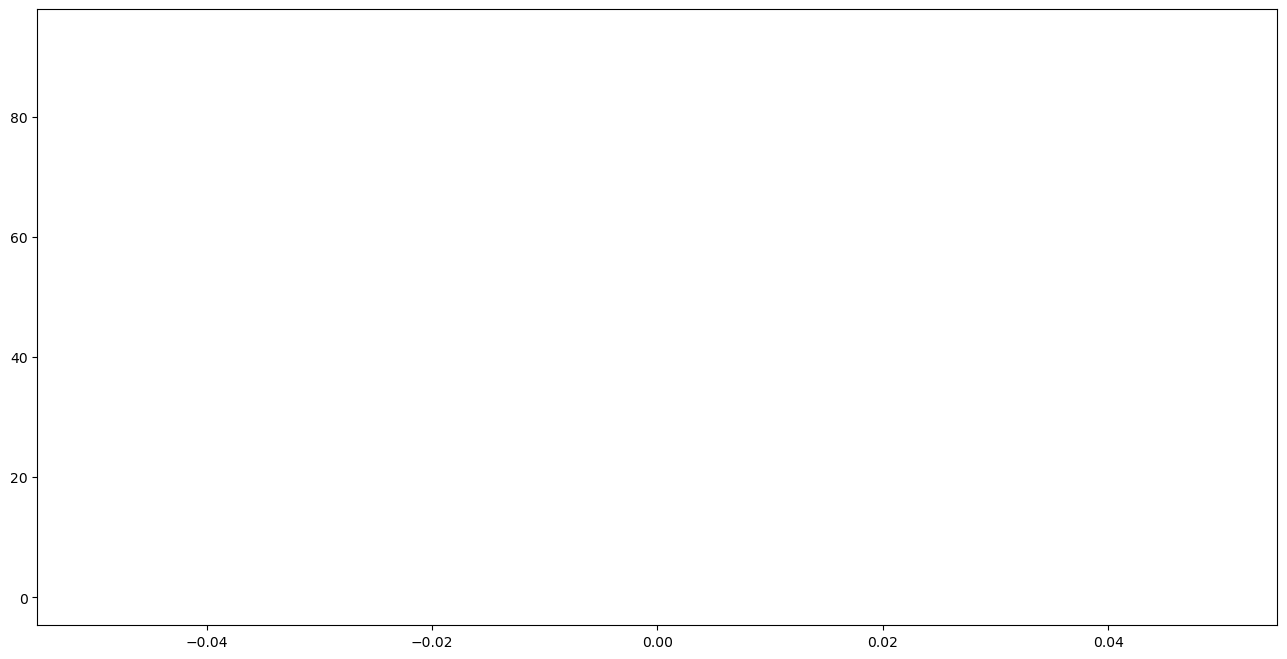

In [25]:
fig, ax = subplots(figsize = (16, 8))
for path in active[hit]:
    ax.plot(path)

In [27]:
active[hit]

array([ 0.        ,  0.        , 42.03641275,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 43.79989313,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       10.28813382,  2.35382835,  9.977372  ,  0.        ,  0.        ,
        0.        ,  0.72006263,  0.        ,  0.        , 22.59

In [61]:
S0 = 100
K = 95
std = 0.25
r = 0.07
T = 1
B = 105
npaths = 1000
nt = 1000
dt = T/nt
method = 'milstein'

paths = []
            
for i in range(npaths):
    S = np.zeros(nt + 1)
    S[0] = S0

    for t in range(nt):
        Z = np.random.normal(loc = 0, scale = 1)
        if method.lower() == 'euler':
            S[t+1] = S[t] + r * S[t] * dt + std * S[t] * np.sqrt(dt) * Z
        if method.lower() == 'milstein':
            # i think the milstein formula in lec notes is incorrect...
            S[t+1] = S[t] + r * S[t] * dt + std * S[t] * (np.sqrt(dt) * Z) + 0.5 * std**2 * ((np.sqrt(dt) * Z)**2 - dt) * S[t]
    
    paths.append(S)   

paths = np.asarray(paths)

S_T = paths[:, -1]

active = np.zeros(npaths)
hit = np.max(paths, axis=1) <= B

active[hit] = np.maximum(S_T[hit] - K, 0)

price = np.exp(-r * T) * np.mean(active)
price

0.027229821570652495

In [81]:
S0 = 100
K = 90
std = 0.25
r = 0.07
T = 1
B = 110
npaths = 1000
nt = 1000
dt = T/nt
method = 'euler'

paths = []
            
for i in range(npaths):
    S = np.zeros(nt + 1)
    S[0] = S0

    for t in range(nt):
        Z = np.random.normal(loc = 0, scale = 1)
        if method.lower() == 'euler':
            S[t+1] = S[t] + r * S[t] * dt + std * S[t] * np.sqrt(dt) * Z
        if method.lower() == 'milstein':
            # i think the milstein formula in lec notes is incorrect...
            S[t+1] = S[t] + r * S[t] * dt + std * S[t] * (np.sqrt(dt) * Z) + 0.5 * std**2 * ((np.sqrt(dt) * Z)**2 - dt) * S[t]
    
    paths.append(S)   

paths = np.asarray(paths)

S_T = paths[:, -1]

active = np.zeros(npaths)
hit = np.max(paths, axis=1) >= B

active[hit] = np.maximum(S_T[hit] - K, 0)

price = np.exp(-r * T) * np.mean(active)
price

18.776049459497706

In [93]:
import numpy as np

def price_down_and_out_cn(
    S0, K, B, T, r, sigma,
    is_call=True,
    rebate=0.0,
    Smax=None,
    N=400,
    M=2000,
    rannacher_steps=2
):
    """
    Crank–Nicolson pricer for down-and-out barrier option (continuous monitoring).
    Dirichlet boundary at S=B is the rebate (usually 0).
    Grid: S in [B, Smax], time marches backward from T to 0.
    """
    if S0 <= B:
        # already knocked out at t=0
        return float(rebate)

    if Smax is None:
        Smax = max(4.0*S0, 4.0*K)  # a sensible default

    # Space grid (start exactly at barrier)
    S = np.linspace(B, Smax, N+1)
    dS = S[1]-S[0]
    dt = T / M

    # Terminal payoff (survivors)
    if is_call:
        V = np.maximum(S - K, 0.0)
        # enforce barrier at maturity
        V[0] = rebate
    else:
        V = np.maximum(K - S, 0.0)
        V[0] = rebate

    # Precompute CN coefficients for interior nodes j=1..N-1
    j = np.arange(1, N)
    Sj = S[j]
    # Black–Scholes operator coefficients
    A = 0.5 * sigma**2 * Sj**2 / dS**2
    Bc = r * Sj / (2.0 * dS)

    # Left matrix (A_L = I + 0.5 dt L)
    aL = -0.5*dt*(A - Bc)      # sub-diagonal
    bL =  1.0 + 0.5*dt*( -2*A - r )  # diagonal
    cL = -0.5*dt*(A + Bc)      # super-diagonal

    # Right matrix (A_R = I - 0.5 dt L)
    aR =  0.5*dt*(A - Bc)
    bR =  1.0 - 0.5*dt*( -2*A - r )
    cR =  0.5*dt*(A + Bc)

    def thomas(a,b,c,d):
        n = len(d)
        c_ = np.empty(n); d_ = np.empty(n)
        c_[0] = c[0]/b[0]; d_[0] = d[0]/b[0]
        for k in range(1, n):
            den = b[k] - a[k]*c_[k-1]
            c_[k] = (c[k]/den) if k < n-1 else 0.0
            d_[k] = (d[k] - a[k]*d_[k-1]) / den
        x = np.empty(n)
        x[-1] = d_[-1]
        for k in range(n-2, -1, -1):
            x[k] = d_[k] - (c_[k]*x[k+1] if k < n-1 else 0.0)
        return x

    for m in range(M):
        t_np1 = m*dt        # later slice time
        t_n   = (m+1)*dt    # current slice time we solve for

        # Right-hand side d = A_R * V^{n+1} + boundary contributions
        Vnp1 = V.copy()
        # enforce right boundary at later time
        if is_call:
            Vnp1[-1] = S[-1] - K*np.exp(-r*(T - t_np1))
        else:
            Vnp1[-1] = 0.0
        # enforce left boundary at later time: knocked-out rebate
        Vnp1[0] = rebate

        d = aR*Vnp1[0:N-1] + bR*Vnp1[1:N] + cR*Vnp1[2:N+1]

        # Add boundary terms from both time levels at the edges (Dirichlet)
        # Left boundary (j=1 uses V[0])
        d[0]  += aR[0]*Vnp1[0] - aL[0]*rebate  # V^n at left is rebate as well
        # Right boundary (j=N-1 uses V[N])
        V_right_n  = (S[-1] - K*np.exp(-r*(T - t_n))) if is_call else 0.0
        d[-1] += cR[-1]*Vnp1[-1] - cL[-1]*V_right_n

        # Rannacher smoothing: replace first few steps with BE (more diffusive)
        if m < rannacher_steps:
            # Backward Euler: (I - dt L) V^n = V^{n+1}
            aBE = -dt*(A - Bc)
            bBE =  1.0 + dt*(-2*A - r)
            cBE = -dt*(A + Bc)

            d_BE = Vnp1[1:N].copy()
            d_BE[0]  += -aBE[0]*rebate     # left boundary
            d_BE[-1] += -cBE[-1]*V_right_n # right boundary
            x = thomas(aBE, bBE, cBE, d_BE)
        else:
            # CN solve: A_L * V^n = d
            x = thomas(aL, bL, cL, d)

        # write current slice & enforce boundaries at t_n
        V[1:N] = x
        V[0]   = rebate
        V[-1]  = V_right_n

    # Interpolate at S0 (grid is increasing)
    return float(np.interp(S0, S, V))

In [101]:
# Example: down-and-out call, zero rebate
S0, K, B, T, r, sigma = 100, 100, 90, 1.0, 0.05, 0.2
price = price_down_and_out_cn(S0, K, B, T, r, sigma, is_call=True, rebate=0.0,
                              Smax=400, N=200, M=8000, rannacher_steps=2)
print(f"Down-and-out call (CN): {price:.6f}")


/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_89294/3480270472.py:83: RuntimeWarning: overflow encountered in multiply
  d = aR*Vnp1[0:N-1] + bR*Vnp1[1:N] + cR*Vnp1[2:N+1]
/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_89294/3480270472.py:83: RuntimeWarning: overflow encountered in add
  d = aR*Vnp1[0:N-1] + bR*Vnp1[1:N] + cR*Vnp1[2:N+1]
/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_89294/3480270472.py:62: RuntimeWarning: overflow encountered in scalar divide
  d_[k] = (d[k] - a[k]*d_[k-1]) / den


Down-and-out call (CN): inf


In [103]:
import numpy as np

# ---------- Safe Thomas solver (pivot guards) ----------
def thomas_safe(a, b, c, d, eps=1e-14):
    """
    Solve tridiagonal system with simple pivot guards:
      a: sub-diagonal (len n-1)
      b: diagonal     (len n)
      c: super-diag   (len n-1)
      d: RHS          (len n)
    Returns x (len n) s.t. tridiag(a,b,c) @ x = d.
    """
    a = np.array(a, dtype=np.float64, copy=True)
    b = np.array(b, dtype=np.float64, copy=True)
    c = np.array(c, dtype=np.float64, copy=True)
    d = np.array(d, dtype=np.float64, copy=True)

    n = d.size
    # forward sweep
    for i in range(1, n):
        denom = b[i-1]
        if abs(denom) < eps:
            denom = eps if denom >= 0 else -eps
        w = a[i-1] / denom
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]
    # guard last pivot
    if abs(b[-1]) < eps:
        b[-1] = eps if b[-1] >= 0 else -eps
    # back substitution
    x = np.empty(n, dtype=np.float64)
    x[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        denom = b[i]
        if abs(denom) < eps:
            denom = eps if denom >= 0 else -eps
        x[i] = (d[i] - c[i]*x[i+1]) / denom
    return x

# ---------- Down-and-out CN pricer ----------
def price_down_and_out_cn(
    S0, K, B, T, r, sigma,
    is_call=True,
    rebate=0.0,
    Smax=None,
    N=200,
    M=8000,
    rannacher_steps=2
):
    """
    Crank–Nicolson for down-and-out barrier (continuous monitoring).
    Grid in s = S/K for better conditioning. Domain: s in [b, smax], b=B/K.
    Dirichlet at s=b equals rebate/K. Right boundary uses vanilla asymptote.
    Returns float price in currency units.
    """
    # knocked-out at inception
    if S0 <= B:
        return float(rebate)

    # sensible Smax default
    if Smax is None:
        Smax = max(4.0*S0, 4.0*K)

    # non-dimensionalization
    s0  = S0 / K
    bnd = B  / K
    smax = Smax / K

    # grids
    s = np.linspace(bnd, smax, N+1)
    ds = s[1] - s[0]
    dt = T / M

    # terminal payoff (survivors only)
    if is_call:
        v = np.maximum(s - 1.0, 0.0)         # v = V/K
    else:
        v = np.maximum(1.0 - s, 0.0)
    v[0] = rebate / K                        # barrier value (rebate)

    # coefficients for interior j=1..N-1
    j = np.arange(1, N)
    sj = s[j]
    # Black–Scholes operator (dimensionless in s)
    A = 0.5 * sigma**2 * (sj**2) / (ds**2)   # diffusion
    Bc = (r * sj) / (2.0 * ds)               # convection

    # Left matrix (CN): (I + 0.5 dt L)
    aL = -0.5*dt*(A - Bc)                    # subdiag
    bL =  1.0 + 0.5*dt*(-2.0*A - r)          # diag
    cL = -0.5*dt*(A + Bc)                    # superdiag

    # Right matrix (CN): (I - 0.5 dt L)
    aR =  0.5*dt*(A - Bc)
    bR =  1.0 - 0.5*dt*(-2.0*A - r)
    cR =  0.5*dt*(A + Bc)

    # Backward Euler (for Rannacher)
    aBE = -dt*(A - Bc)
    bBE =  1.0 + dt*(-2.0*A - r)
    cBE = -dt*(A + Bc)

    # helper: right boundary value (asymptote) at time t
    def right_boundary_call(t):
        # V(Smax,t) ≈ Smax - K e^{-r(T-t)}  => v(smax,t) = smax - e^{-r(T-t)}
        return smax - np.exp(-r*(T - t))
    def right_boundary_put(t):
        # V(Smax,t) ≈ 0 => v(smax,t) = 0
        return 0.0

    # quick conditioning check (parabolic number at top node)
    nu_max = 0.5 * sigma**2 * (smax**2) * dt / (ds**2)
    if nu_max > 1.0:
        # warn the user numerically via comment; algorithm still runs due to guarded solver
        # (if needed, increase M or reduce N to lower nu_max)
        pass

    # time-march
    for m in range(M):
        t_np1 = m*dt
        t_n   = (m+1)*dt

        # build RHS using the later slice v^{n+1}, with boundaries enforced
        v_np1 = v.copy()
        v_np1[0] = rebate / K
        v_np1[-1] = right_boundary_call(t_np1) if is_call else right_boundary_put(t_np1)

        d = aR * v_np1[0:N-1] + bR * v_np1[1:N] + cR * v_np1[2:N+1]

        # add Dirichlet boundary contributions (both time levels)
        # left edge j=1 uses v(b,t): rebate/K at both times
        v_left_n = rebate / K
        d[0]  += aR[0]*v_np1[0] - aL[0]*v_left_n

        # right edge j=N-1 uses v(smax,t)
        v_right_np1 = v_np1[-1]
        v_right_n   = right_boundary_call(t_n) if is_call else right_boundary_put(t_n)
        d[-1] += cR[-1]*v_right_np1 - cL[-1]*v_right_n

        # scheme: Rannacher for first steps, then CN
        if m < rannacher_steps:
            d_BE = v_np1[1:N].copy()
            d_BE[0]  += -aBE[0]*v_left_n
            d_BE[-1] += -cBE[-1]*v_right_n
            x = thomas_safe(aBE, bBE, cBE, d_BE)
        else:
            x = thomas_safe(aL, bL, cL, d)

        # write current slice & boundaries at t_n
        v[1:N] = x
        v[0]   = v_left_n
        v[-1]  = v_right_n

    # interpolate at s0 (grid is increasing)
    price = np.interp(s0, s, v) * K
    return float(price)

# ---------- Example usage ----------
if __name__ == "__main__":
    S0, K, B, T, r, sigma = 100.0, 100.0, 90.0, 1.0, 0.05, 0.20
    price = price_down_and_out_cn(
        S0, K, B, T, r, sigma,
        is_call=True,
        rebate=0.0,
        Smax=400.0,   # ~4x is fine
        N=200,        # moderate space
        M=8000,       # time big enough for stability/conditioning
        rannacher_steps=2
    )
    print(f"Down-and-out call (CN): {price:.6f}")

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_89294/1074508606.py:37: RuntimeWarning: overflow encountered in scalar divide
  x[i] = (d[i] - c[i]*x[i+1]) / denom


Down-and-out call (CN): inf


In [109]:
import numpy as np
from math import exp
from scipy.linalg import solve_banded

def price_down_and_out_cn_banded(
    S0, K, B, T, r, sigma,
    is_call=True,
    rebate=0.0,
    Smax=None,
    N=200,
    M=12000,
    rannacher_steps=2
):
    if S0 <= B:
        return float(rebate)
    if Smax is None:
        Smax = max(4.0*S0, 4.0*K)

    # dimensionless vars
    s0   = S0 / K
    smax = Smax / K
    bnd  = B  / K

    s  = np.linspace(bnd, smax, N+1, dtype=np.float64)  # j=0..N
    ds = s[1] - s[0]
    dt = T / M

    # terminal payoff (v = V/K)
    v = np.maximum(s - 1.0, 0.0) if is_call else np.maximum(1.0 - s, 0.0)
    v[0] = rebate / K

    # interior j=1..N-1
    sj = s[1:N]
    A = 0.5 * sigma**2 * (sj**2) / (ds**2)
    C = (r * sj) / (2.0 * ds)

    # CN left/right; BE for Rannacher
    aL = -0.5*dt*(A - C);  bL = 1.0 + 0.5*dt*(-2.0*A - r);  cL = -0.5*dt*(A + C)
    aR =  0.5*dt*(A - C);  bR = 1.0 - 0.5*dt*(-2.0*A - r);  cR =  0.5*dt*(A + C)
    aBE= -dt*(A - C);      bBE= 1.0 + dt*(-2.0*A - r);      cBE= -dt*(A + C)

    n = N-1  # interior size

    def pack_banded(a, b, c):
        """
        Create ab for solve_banded((1,1), ab, d):
          ab[0,1:] = superdiag, ab[0,0]=0
          ab[1,:]  = diag
          ab[2,:-1]= subdiag,   ab[2,-1]=0
        """
        ab = np.zeros((3, n), dtype=np.float64)
        ab[0, 1:] = c[:-1]   # super
        ab[1, :]  = b        # diag
        ab[2, :-1]= a[1:]    # sub
        return ab

    AL_b  = pack_banded(aL,  bL,  cL)   # CN left matrix
    ABE_b = pack_banded(aBE, bBE, cBE)  # BE left matrix

    def v_right_call(t):  # v(smax,t) = smax - e^{-r(T-t)}
        return smax - exp(-r*(T - t))
    def v_right_put(t):   # ≈ 0
        return 0.0

    # (diagnostic) parabolic number
    # nu_max = 0.5 * sigma**2 * (smax**2) * dt / (ds**2)
    # print("nu_max =", nu_max)

    for m in range(M):
        t_np1 = m*dt
        t_n   = (m+1)*dt

        v_np1 = v.copy()
        v_np1[0]  = rebate / K
        v_np1[-1] = v_right_call(t_np1) if is_call else v_right_put(t_np1)

        # RHS on interior 1..N-1
        d = aR * v_np1[0:N-1] + bR * v_np1[1:N] + cR * v_np1[2:N+1]

        # Dirichlet boundaries at both time levels
        v_left_n  = rebate / K
        v_right_n = v_right_call(t_n) if is_call else v_right_put(t_n)
        d[0]  += -aL[0]*v_left_n + aR[0]*v_np1[0]
        d[-1] += -cL[-1]*v_right_n + cR[-1]*v_np1[-1]

        if not np.isfinite(d).all():
            raise ValueError(f"RHS non-finite at step {m}")

        # Solve (BE for first few steps = Rannacher)
        if m < rannacher_steps:
            x = solve_banded((1,1), ABE_b, d, overwrite_ab=True, overwrite_b=False)
        else:
            x = solve_banded((1,1), AL_b,  d, overwrite_ab=True, overwrite_b=False)

        if not np.isfinite(x).all():
            raise ValueError(f"Solution non-finite at step {m}")

        # write current slice + enforce boundaries
        v[1:N] = x
        v[0]   = v_left_n
        v[-1]  = v_right_n

    return float(np.interp(s0, s, v) * K)

In [113]:
S0, K, B, T, r, sigma = 100.0, 100.0, 90.0, 1.0, 0.07, 0.25
print(price_down_and_out_cn_banded(S0,K,B,T,r,sigma, True, 0.0, 400.0, N=200, M=12000))

ValueError: Solution non-finite at step 1072